In [1]:
import numpy as np
import pickle
import torch
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm
DEVICE = "cuda"

/home/kleincode/miniconda3/envs/csmae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("train_new.pkl", "rb") as f:
    train_keys, Y_train, X_train = pickle.load(f)
len(train_keys), Y_train.shape, X_train.shape

(269695, (269695, 43), (269695, 768))

In [3]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32, device=DEVICE)
train_set = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [14]:
model = nn.Sequential(
    nn.Linear(768, 384),
    nn.ReLU(),
    nn.Linear(384, 192),
    nn.ReLU(),
    nn.Linear(192, 100),
    nn.ReLU(),
    nn.Linear(100, 43)
).to(DEVICE)

In [15]:
len(train_dataloader)

4214

In [16]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=3e-4)

losses = []
for epoch in range(3):
    progress = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for X_batch, Y_batch in progress:
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        progress.set_postfix(loss=losses[-1])

Epoch 0:   0%|          | 0/4214 [00:00<?, ?it/s]

Epoch 2: 100%|██████████| 4214/4214 [00:09<00:00, 439.21it/s, loss=0.123] 


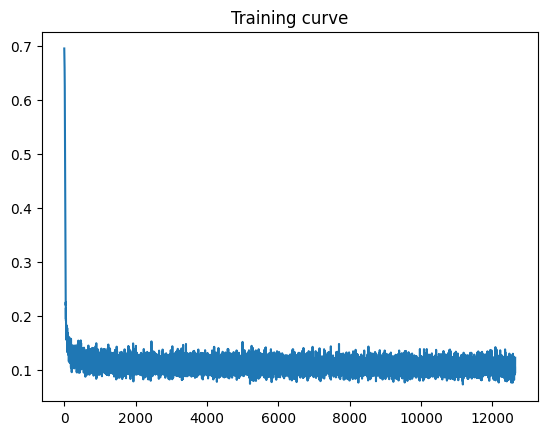

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training curve")
plt.show()

In [18]:
progress = tqdm(train_dataloader, desc=f"Testing")
accs = []
for X_batch, Y_batch in progress:
    Y_pred = model(X_batch)
    acc = ((Y_pred > 0) == Y_batch).cpu().numpy().mean()
    accs.append(acc)
acc = np.mean(accs)
print(f"Training Accuracy: {acc:.2%}")

Testing: 100%|██████████| 4214/4214 [00:02<00:00, 2033.53it/s]

Training Accuracy: 95.70%


In [19]:
with open("test_new.pkl", "rb") as f:
    test_keys, Y_test, X_test = pickle.load(f)
len(test_keys), Y_test.shape, X_test.shape

(125866, (125866, 43), (125866, 768))

In [20]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32, device=DEVICE)
test_set = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [21]:
progress = tqdm(test_dataloader, desc=f"Testing")
preds = []
for X_batch, Y_batch in progress:
    y_pred = model(X_batch)
    preds.append(y_pred.cpu().detach().numpy())
Y_pred = np.concatenate(preds)

Testing: 100%|██████████| 1967/1967 [00:00<00:00, 2019.76it/s]


In [22]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score

f1_total = f1_score(Y_test, Y_pred > 0, average="micro")
print(f"Test F1: {f1_total:.2%}")
f1_per_class = f1_score(Y_test, Y_pred > 0, average=None)
print(f"Test F1 per class: {', '.join(f'{f1:.2%}' for f1 in f1_per_class)}")

# "In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true."
subset_accuracy = accuracy_score(Y_test, Y_pred > 0)
print(f"Test Subset Accuracy: {subset_accuracy:.2%}")
accuracy_per_class = [accuracy_score(Y_test[:, i], Y_pred[:, i] > 0) for i in range(Y_test.shape[1])]
print(f"Test Accuracy per class: {', '.join(f'{acc:.2%}' for acc in accuracy_per_class)}")

precision_total = precision_score(Y_test, Y_pred > 0, average="micro")
print(f"Test Precision: {precision_total:.2%}")
precision_per_class = precision_score(Y_test, Y_pred > 0, average=None)
print(f"Test Precision per class: {', '.join(f'{precision:.2%}' for precision in precision_per_class)}")

recall_total = recall_score(Y_test, Y_pred > 0, average="micro")
print(f"Test Recall: {recall_total:.2%}")
recall_per_class = recall_score(Y_test, Y_pred > 0, average=None)
print(f"Test Recall per class: {', '.join(f'{recall:.2%}' for recall in recall_per_class)}")

balanced_accuracy_per_class = [balanced_accuracy_score(Y_test[:, i], Y_pred[:, i] > 0) for i in range(Y_test.shape[1])]
print(f"Test Balanced Accuracy per class: {', '.join(f'{balanced_accuracy:.2%}' for balanced_accuracy in balanced_accuracy_per_class)}")

Test F1: 65.19%
Test F1 per class: 33.62%, 64.47%, 30.72%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 1.37%, 0.00%, 78.00%, 1.72%, 0.00%, 0.00%, 7.37%, 0.52%, 60.27%, 20.30%, 55.38%, 54.51%, 63.53%, 62.41%, 78.42%, 74.59%, 14.26%, 20.49%, 37.79%, 52.70%, 29.85%, 0.00%, 17.94%, 0.00%, 0.00%, 38.47%, 0.00%, 0.00%, 0.00%, 35.03%, 71.49%, 0.00%, 0.00%, 92.18%
Test Subset Accuracy: 25.39%
Test Accuracy per class: 98.06%, 92.36%, 97.85%, 99.59%, 99.94%, 99.89%, 99.62%, 99.93%, 99.87%, 99.77%, 99.52%, 84.22%, 97.37%, 99.48%, 98.21%, 99.42%, 97.57%, 87.83%, 98.65%, 84.57%, 80.17%, 96.09%, 81.81%, 86.73%, 82.66%, 97.98%, 99.10%, 98.05%, 77.48%, 99.81%, 99.65%, 99.85%, 99.97%, 98.93%, 97.37%, 99.79%, 99.92%, 99.87%, 98.33%, 93.73%, 99.72%, 99.80%, 97.88%
Test Precision: 74.51%


/home/kleincode/miniconda3/envs/csmae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision per class: 59.22%, 77.04%, 54.85%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 66.67%, 0.00%, 77.38%, 47.54%, 0.00%, 0.00%, 34.12%, 50.00%, 80.82%, 55.22%, 67.41%, 65.54%, 68.69%, 70.97%, 80.16%, 74.05%, 74.04%, 59.11%, 59.60%, 66.57%, 43.86%, 0.00%, 34.48%, 0.00%, 0.00%, 76.58%, 0.00%, 0.00%, 0.00%, 61.67%, 72.06%, 0.00%, 0.00%, 94.19%
Test Recall: 57.94%
Test Recall per class: 23.48%, 55.43%, 21.33%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.69%, 0.00%, 78.64%, 0.88%, 0.00%, 0.00%, 4.13%, 0.26%, 48.06%, 12.44%, 46.99%, 46.66%, 59.10%, 55.69%, 76.74%, 75.14%, 7.89%, 12.39%, 27.66%, 43.61%, 22.62%, 0.00%, 12.12%, 0.00%, 0.00%, 25.69%, 0.00%, 0.00%, 0.00%, 24.46%, 70.94%, 0.00%, 0.00%, 90.26%
Test Balanced Accuracy per class: 61.56%, 76.53%, 60.47%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 50.34%, 50.00%, 82.97%, 50.43%, 50.00%, 50.00%, 52.04%, 50.13%, 72.67%, 56.15%, 70.59%, 69.14%, 78.72%, 73.61%, 84.02%, 80.83%, 53.91%, 56.16%, 63.63%, 67.38%, 61.29%, 50.00%, 56

Old:

```
Test F1: 43.04%
Test F1 per class: 2.10%, 39.75%, 32.22%, 0.00%, 22.92%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 60.16%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 24.03%, 0.00%, 0.00%, 7.67%, 21.21%, 27.64%, 63.38%, 58.18%, 0.22%, 0.00%, 0.00%, 32.55%, 0.00%, 0.00%, 10.95%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 59.49%, 0.00%, 0.00%, 89.05%
Test Subset Accuracy: 18.57%
Test Accuracy per class: 97.92%, 89.84%, 98.01%, 99.59%, 99.94%, 99.89%, 99.62%, 99.93%, 99.87%, 99.77%, 99.52%, 74.46%, 97.38%, 99.48%, 98.21%, 99.44%, 97.57%, 81.75%, 98.61%, 79.63%, 74.69%, 94.32%, 75.32%, 80.08%, 76.15%, 97.87%, 99.06%, 97.86%, 72.35%, 99.82%, 99.65%, 99.86%, 99.97%, 98.93%, 96.81%, 99.79%, 99.92%, 99.87%, 98.16%, 92.56%, 99.72%, 99.80%, 97.01%
Test Precision: 70.88%
/home/kleincode/miniconda3/envs/csmae/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Test Precision per class: 90.32%, 76.76%, 66.89%, 0.00%, 68.75%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 67.62%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 59.85%, 0.00%, 0.00%, 53.97%, 53.12%, 67.42%, 74.96%, 71.65%, 42.86%, 0.00%, 0.00%, 54.59%, 0.00%, 0.00%, 30.56%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 75.12%, 0.00%, 0.00%, 90.57%
Test Recall: 30.90%
Test Recall per class: 1.06%, 26.82%, 21.23%, 0.00%, 13.75%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 54.18%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 15.04%, 0.00%, 0.00%, 4.13%, 13.25%, 17.38%, 54.90%, 48.97%, 0.11%, 0.00%, 0.00%, 23.19%, 0.00%, 0.00%, 6.67%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 49.25%, 0.00%, 0.00%, 87.57%
Test Balanced Accuracy per class: 50.53%, 62.83%, 60.49%, 50.00%, 56.87%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 69.92%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 56.32%, 50.00%, 50.00%, 51.46%, 56.27%, 57.13%, 73.25%, 69.52%, 50.05%, 50.00%, 50.00%, 57.70%, 50.00%, 50.00%, 53.32%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 50.00%, 73.61%, 50.00%, 50.00%, 93.05%
```